2024-09-27 14:24:55.273297: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 14:24:55.544451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 14:24:55.544577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 14:24:55.584107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 14:24:55.666555: I tensorflow/core/platform/cpu_feature_guar

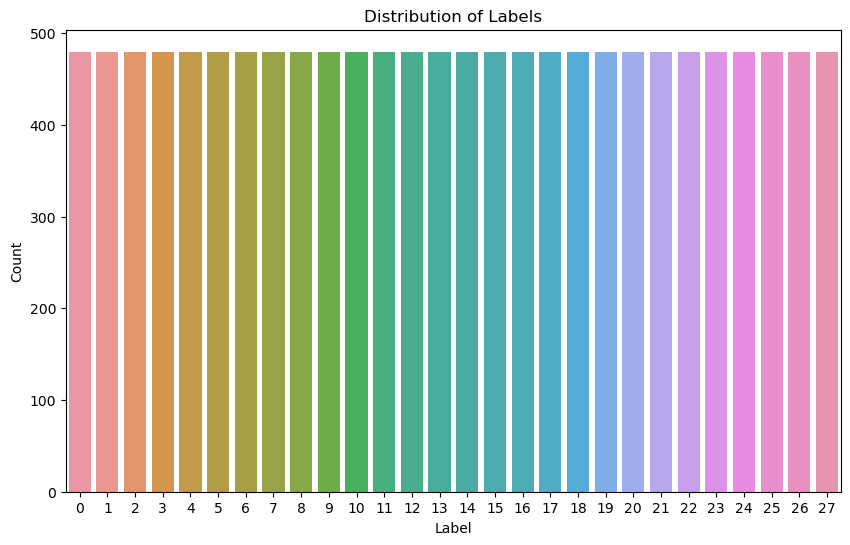

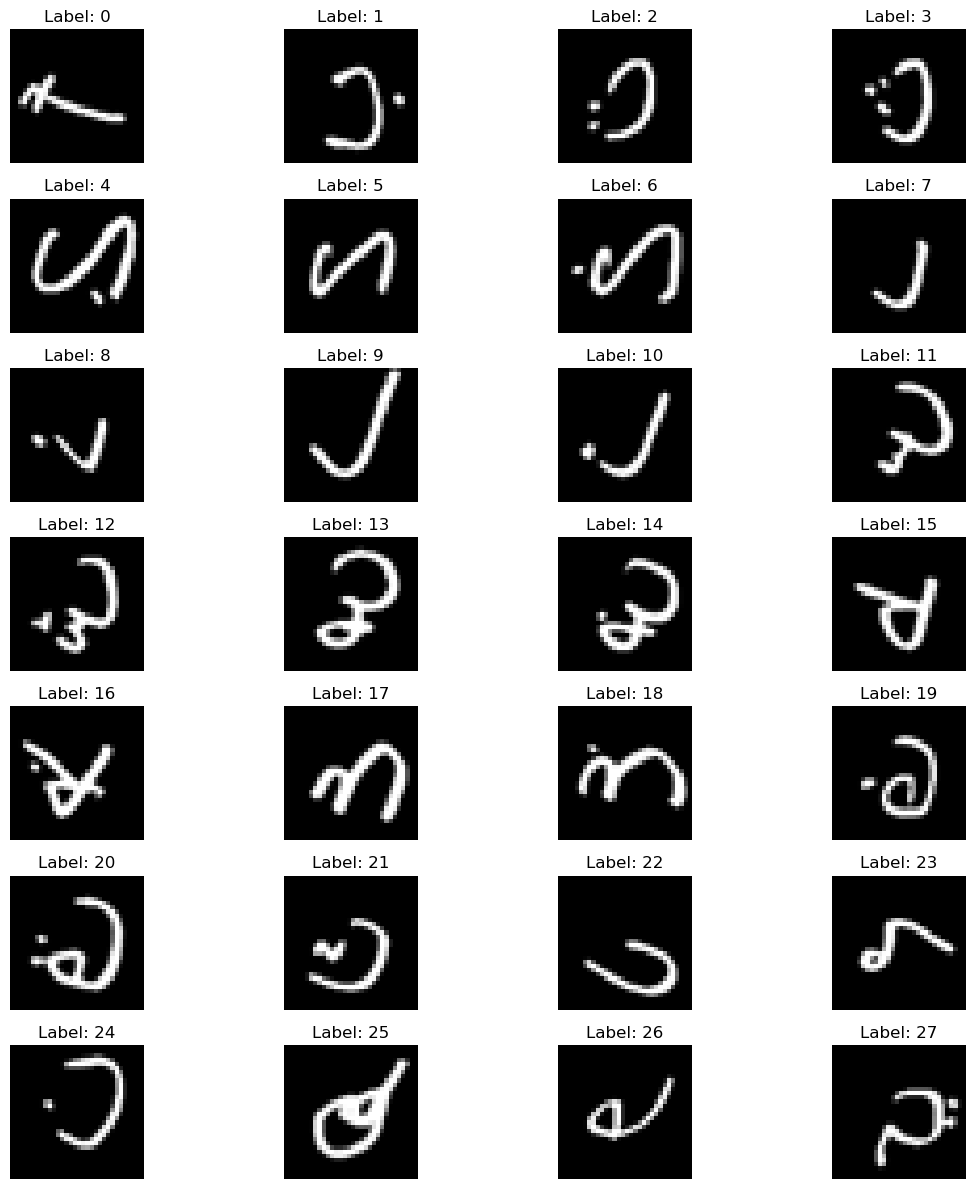

Epoch 1/100
336/336 [==============================] - 7s 17ms/step - loss: 2.6516 - accuracy: 0.2015 - val_loss: 1.2922 - val_accuracy: 0.5621
Epoch 2/100
336/336 [==============================] - 6s 17ms/step - loss: 1.5421 - accuracy: 0.4773 - val_loss: 0.7683 - val_accuracy: 0.7299
Epoch 3/100
336/336 [==============================] - 5s 16ms/step - loss: 1.1531 - accuracy: 0.6084 - val_loss: 0.5809 - val_accuracy: 0.7961
Epoch 4/100
336/336 [==============================] - 5s 16ms/step - loss: 0.9368 - accuracy: 0.6778 - val_loss: 0.4791 - val_accuracy: 0.8151
Epoch 5/100
336/336 [==============================] - 6s 18ms/step - loss: 0.8189 - accuracy: 0.7191 - val_loss: 0.3601 - val_accuracy: 0.8702
Epoch 6/100
336/336 [==============================] - 5s 15ms/step - loss: 0.7193 - accuracy: 0.7511 - val_loss: 0.3353 - val_accuracy: 0.8824
Epoch 7/100
336/336 [==============================] - 5s 15ms/step - loss: 0.6388 - accuracy: 0.7831 - val_loss: 0.3186 - val_accuracy:

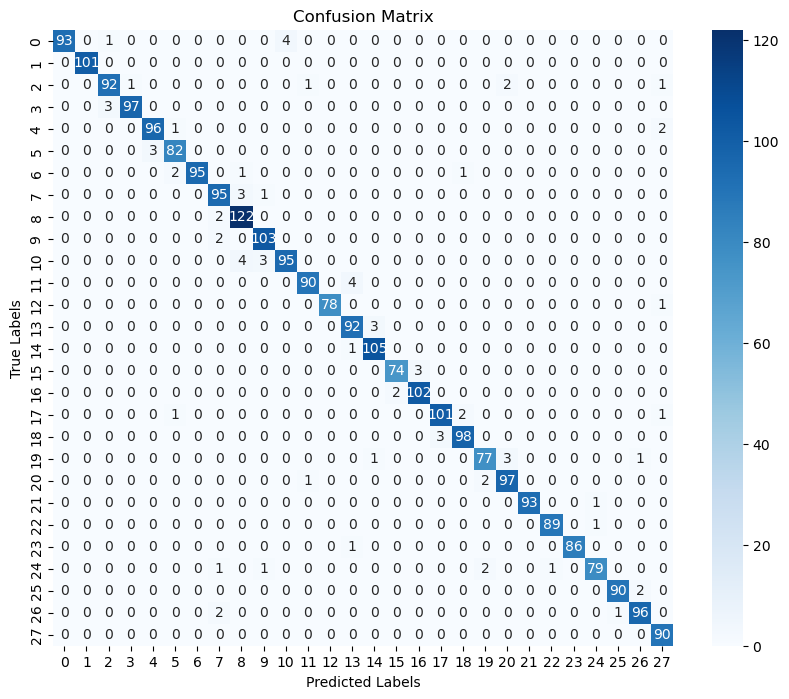

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        98
           1       1.00      1.00      1.00       101
           2       0.96      0.95      0.95        97
           3       0.99      0.97      0.98       100
           4       0.97      0.97      0.97        99
           5       0.95      0.96      0.96        85
           6       1.00      0.96      0.98        99
           7       0.93      0.96      0.95        99
           8       0.94      0.98      0.96       124
           9       0.95      0.98      0.97       105
          10       0.96      0.93      0.95       102
          11       0.98      0.96      0.97        94
          12       1.00      0.99      0.99        79
          13       0.94      0.97      0.95        95
          14       0.96      0.99      0.98       106
          15       0.97      0.96      0.97        77
          16       0.97      0.98      0.98       104
          17       0.97    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Load the images and labels
images_file = 'images.csv'
labels_file = 'labels.csv'

x = pd.read_csv(images_file, header=None).values
y = pd.read_csv(labels_file, header=None).values.flatten()  # Flatten to 1D array

# Adjust labels if needed (ensure labels are in range [0, 27])
if np.max(y) >= 28:
    y -= 1  

# EDA: Visualize the distribution of the labels
plt.figure(figsize=(10, 6))
sns.countplot(y)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# EDA: Display a few sample images from each class
plt.figure(figsize=(12, 12))
for i in range(0, 28):
    plt.subplot(7, 4, i + 1)
    sample_image = x[y == i][0].reshape(32, 32)
    plt.imshow(sample_image, cmap='gray')
    plt.title(f'Label: {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Normalize images to [0, 1]
x = x / 255.0

# Reshape images to 32x32x1 (grayscale)
x = x.reshape(-1, 32, 32, 1)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Start Building the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(28, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('arabic_letters_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=100,  # Adjust number of epochs as needed
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

# Load the best model
model = tf.keras.models.load_model('arabic_letters_model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Generate predictions and create the confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optionally, print a classification report for more detailed metrics
print(classification_report(y_test, y_pred_classes))


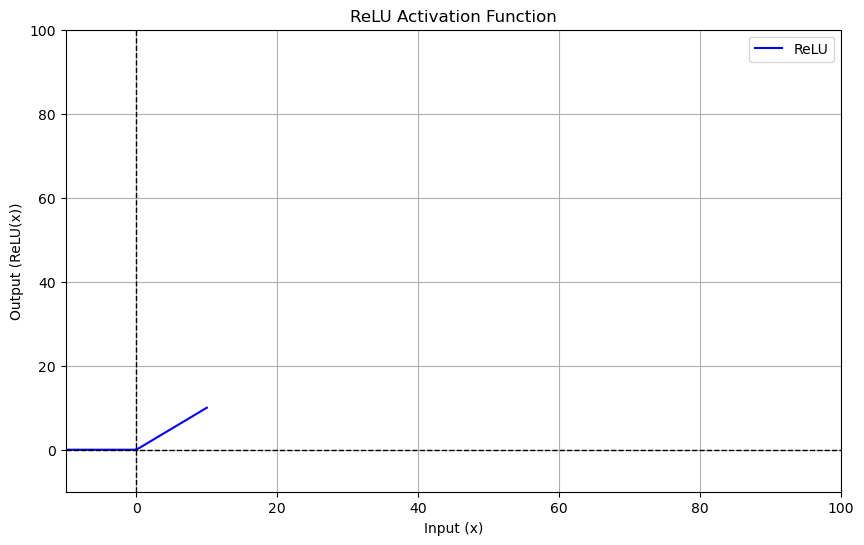

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Create an array of input values from -1000 to 1000 with 400 points
x = np.linspace(-10, 10, 40, 2)
y = relu(x)

# Plot ReLU function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="ReLU", color='blue')
plt.title("ReLU Activation Function")
plt.xlabel("Input (x)")
plt.ylabel("Output (ReLU(x))")
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.grid(True)
plt.legend()
plt.xlim(-10, 100)  # Set x-axis limits for better visibility
plt.ylim(-10, 100)   # Set y-axis limits for better visibility
plt.show()
